In [1]:
library(tidyverse)
library(umap)

# Custom package
library(rutils)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
projects <- c("TCGA-CESC", "TCGA-UCS", "TCGA-UCEC", "TCGA-OV")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
matrisome_path <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")

In [3]:
i <- 1

In [4]:
matrisome_df <- load_matrisome_df(matrisome_path)

Parsed with column specification:
cols(
  Division = col_character(),
  Category = col_character(),
  `Gene Symbol` = col_character(),
  `Gene Name` = col_character(),
  Synonyms = col_character(),
  HGNC_IDs = col_double(),
  `HGNC_IDs Links` = col_double(),
  UniProt_IDs = col_character(),
  Refseq_IDs = col_character(),
  Orthology = col_character(),
  Notes = col_character()
)


In [5]:
seed = 123

# Load and filter survival data

In [6]:
event_code <- list("Alive" = 0, "Dead" = 1)
covariate_cols <- c("figo_stage", "age_at_diagnosis", "race", "ethnicity")
dep_cols <- c("vital_status", "survival_time")
figo_map_df <- tibble(
    roman_num = c("I", "II", "III", "IV"),
    figo_code = c('1', '2', '3', '4')
)

In [7]:
# survival_df <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[i], "/survival_data.tsv"))
survival_path <- paste0(dirs$data_dir, "/", unified_dsets[i], "/survival_data.tsv")
survival_df <- load_survival_df(survival_path, event_code)
filtered_survival_df <- survival_df %>%
    dplyr::select(one_of(c("sample_name", dep_cols, covariate_cols))) %>%
    dplyr::filter(rowSums(is.na(.)) == 0) %>%
    dplyr::mutate(
        figo_rn = str_extract(figo_stage, "IV|III|II|I")
    ) %>%
    dplyr::inner_join(figo_map_df, by = c("figo_rn" = "roman_num")) %>%
    dplyr::select(-c(figo_rn, figo_stage)) %>%
    dplyr::rename(figo_stage = figo_code)

Parsed with column specification:
cols(
  sample_name = col_character(),
  vital_status = col_character(),
  survival_time = col_double(),
  figo_stage = col_character(),
  days_to_last_follow_up = col_double(),
  days_to_death = col_double(),
  age_at_diagnosis = col_double(),
  age_at_index = col_double(),
  height = col_double(),
  weight = col_double(),
  bmi = col_double(),
  race = col_character(),
  ethnicity = col_character()
)


# Load normalized matrisome count data

In [8]:
norm_matrisome_counts <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[i], "/norm_matrisome_counts.tsv")) %>%
    column_to_rownames(var = "geneID") %>%
    as.matrix()

# Match up columns of counts with rows of survival data & only include samples present in survival data
norm_matrisome_survival_counts <- norm_matrisome_counts[, filtered_survival_df$sample_name]

Parsed with column specification:
cols(
  .default = col_double(),
  geneID = col_character()
)
See spec(...) for full column specifications.


In [9]:
all(rownames(t(norm_matrisome_survival_counts)) == filtered_survival_df$sample_name)

[1] TRUE

# Combine filtered survival data and normalized count data

In [10]:
joined_df <- filtered_survival_df %>%
    inner_join(
        as_tibble(t(norm_matrisome_survival_counts), rownames = "sample_name"),
        by = "sample_name"
    )
nrow(joined_df)
head(joined_df)

# Some genes contain the '-' symbol, which affects formulae
colnames(joined_df) <- gsub("-", "_", colnames(joined_df))

[1] 255

sample_name,vital_status,survival_time,age_at_diagnosis,race,ethnicity,figo_stage,PGF,TIMP4,C1QTNF6,⋯,PIK3IP1,C1QTNF2,PCSK5,ANXA1,HGF,VWA2,FGF3,POSTN,NTF3,S100A6
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TCGA-C5-A1BF-01B-11R-A13Y-07,1,570,16975,white,not reported,1,10.800637,6.228003,11.669331,⋯,9.013453,8.190325,9.503647,14.07799,6.569726,7.315604,4.602649,12.062300,5.649441,16.55841
TCGA-MU-A51Y-01A-11R-A26T-07,0,854,10199,white,not reported,2,8.451001,5.851272,10.079584,⋯,12.208410,8.172899,10.515388,16.88600,7.384140,7.366949,4.890169,11.011959,5.406776,14.76108
TCGA-EK-A2RM-01A-21R-A18M-07,0,50,14842,white,not hispanic or latino,1,9.674879,7.277164,10.712783,⋯,10.854224,6.581217,8.437154,15.81626,7.644559,6.406766,4.998296,11.731128,6.028879,17.11959
TCGA-Q1-A73P-01A-11R-A32P-07,0,483,16450,white,not hispanic or latino,1,8.036801,5.247645,9.894159,⋯,10.854487,5.629541,9.602922,14.17475,6.987468,6.731154,4.602649,9.293089,4.893018,16.64949
TCGA-C5-A8YT-01A-11R-A37O-07,1,633,13253,white,not hispanic or latino,1,7.830611,5.733875,12.445548,⋯,9.453187,6.398956,12.288955,13.39633,10.228758,8.542025,4.602649,11.765396,5.318924,13.55632
TCGA-C5-A2LZ-01A-11R-A213-07,1,3046,24059,white,not hispanic or latino,3,10.135550,4.865349,8.566221,⋯,11.492135,7.426145,9.480199,15.92715,6.010764,7.405245,4.602649,7.506731,5.423416,14.73802


In [11]:
deceased_joined_df <- joined_df %>%
    dplyr::filter(vital_status == 1) %>%
    dplyr::select(-vital_status)

quantiles <- as.vector(quantile(deceased_joined_df$survival_time))
iqr <- quantiles[4] - quantiles[2]
coef <- 1.5
outlier_thresh <- list(min = quantiles[1] - coef * iqr, max = quantiles[4] + coef * iqr)

deceased_joined_df <- deceased_joined_df %>%
    dplyr::mutate(observation_type = case_when(
        ((survival_time < outlier_thresh$min) | (outlier_thresh$max < survival_time)) ~ "outlier",
        ((outlier_thresh$min < survival_time) & (survival_time < outlier_thresh$max)) ~ "regular"
    ))

# Look at group counts & survival times for the deceased cohort

In [12]:
deceased_joined_df %>%
    group_by(figo_stage) %>%
    summarize(
        n = n(),
        mean_survival = mean(survival_time) / 365,
        median_survival = median(survival_time) / 365,
        survival_iqr = IQR(survival_time / 365),
        min_survival = min(survival_time) / 365,
        max_survival = max(survival_time) / 365
    )

`summarise()` ungrouping output (override with `.groups` argument)


figo_stage,n,mean_survival,median_survival,survival_iqr,min_survival,max_survival
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,34,2.566720,2.038356,1.532877,0.03835616,7.832877
2,8,2.427740,1.369863,1.839726,0.14246575,8.484932
3,10,2.199178,1.250685,1.970548,0.20273973,8.345205
4,14,1.854599,1.046575,1.605479,0.27397260,11.194521


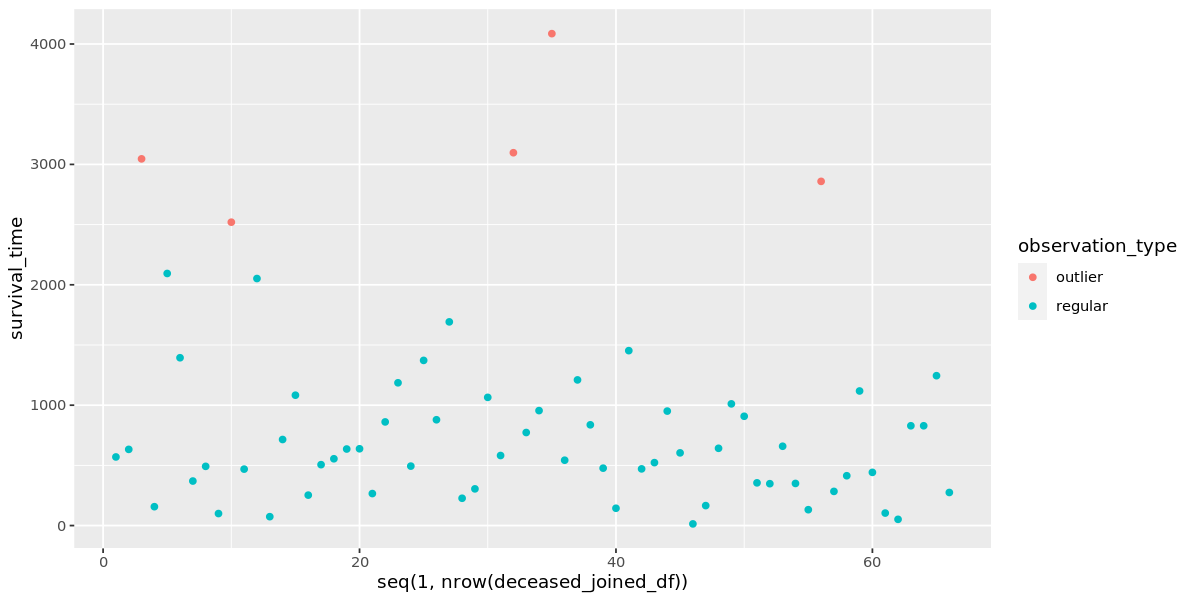

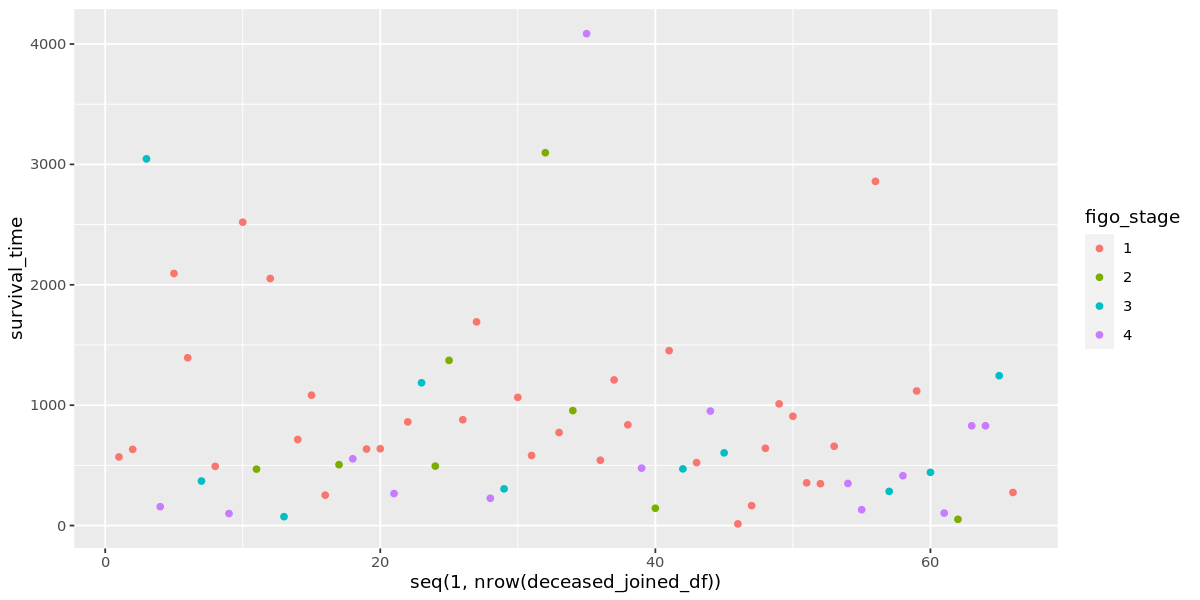

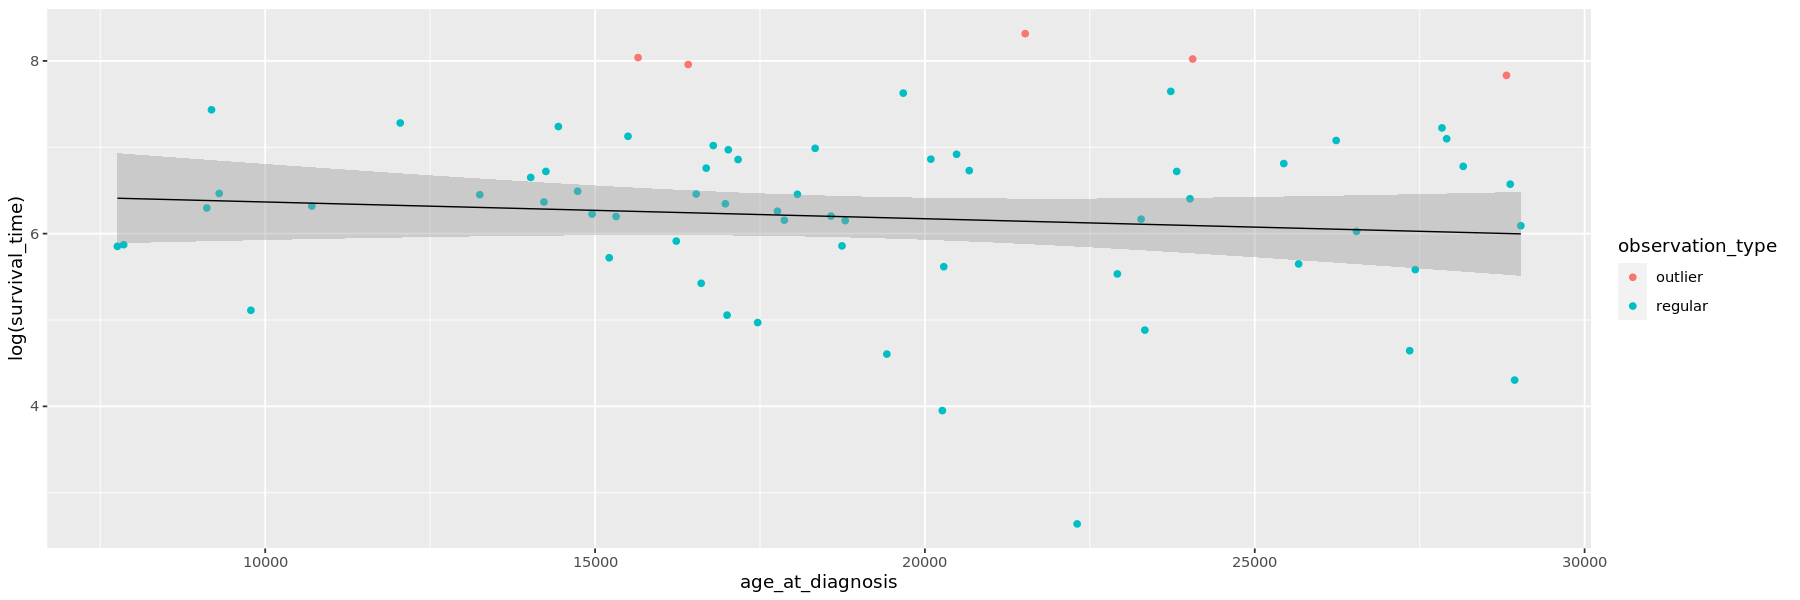

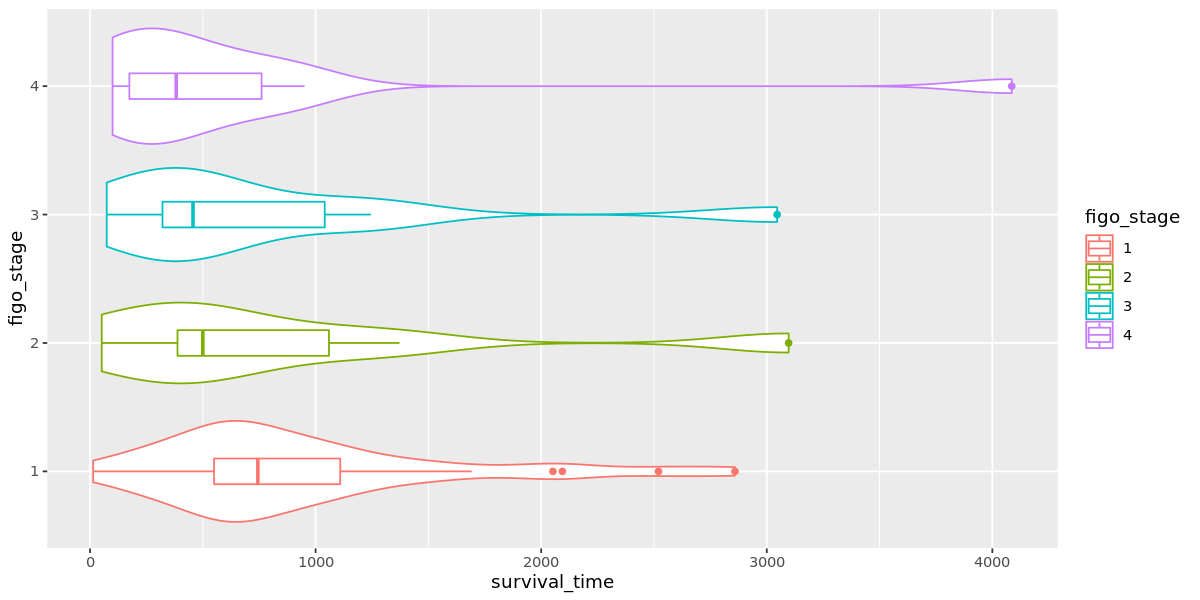

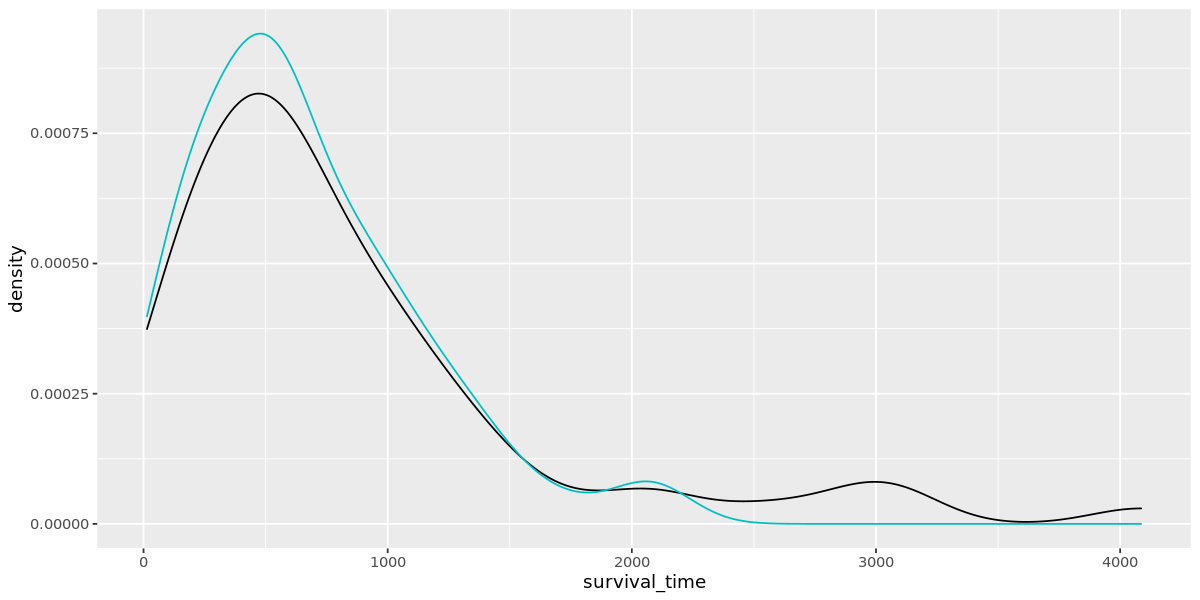

In [13]:
options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(data=deceased_joined_df) +
    geom_point(aes(x = seq(1, nrow(deceased_joined_df)), y = survival_time, color=observation_type))
ggplot(data=deceased_joined_df) +
    geom_point(aes(x = seq(1, nrow(deceased_joined_df)), y = survival_time, color=figo_stage))
options(repr.plot.width = 15, repr.plot.height = 5)
ggplot() +
    geom_point(data = deceased_joined_df, aes(x = age_at_diagnosis, y = log(survival_time), color=observation_type)) +
    geom_smooth(
        data = deceased_joined_df %>% dplyr::filter(observation_type == "regular"),
        aes(x = age_at_diagnosis, y = log(survival_time), color = "fit"),
        method = "lm",
#         se = FALSE,
        formula = y ~ x,
        color = "black",
        size = 0.4
    )
options(repr.plot.width = 10, repr.plot.height = 5)
# ggplot(data=deceased_joined_df) +
#     geom_boxplot(aes(x = survival_time))
ggplot(data=deceased_joined_df) +
    geom_violin(aes(x = survival_time, y = figo_stage, color = figo_stage)) +
    geom_boxplot(aes(x = survival_time, y = figo_stage, color = figo_stage), width = 0.2)
ggplot() +
    geom_density(data = deceased_joined_df, aes(x = survival_time), color = "black") +
    geom_density(
        data = deceased_joined_df %>% dplyr::filter(observation_type == "regular"),
        aes(x = survival_time),
        color = "#00BFC4"
    )

In [14]:
quantiles <- quantile(deceased_joined_df$survival_time)

processed_deceased_joined_df <- deceased_joined_df %>%
    dplyr::select(-"observation_type") %>%
    bind_cols(to_one_hot(., "race")) %>%
    bind_cols(to_one_hot(., "ethnicity")) %>%
    bind_cols(to_one_hot(., "figo_stage")) %>%
    dplyr::select(-c("race", "ethnicity", "figo_stage")) %>%
    dplyr::mutate(survival_class = case_when(
        (survival_time < quantiles[2]) ~ "low",
        (quantiles[2] <= survival_time) & (survival_time < quantiles[3]) ~ "low_med",
        (quantiles[3] <= survival_time) & (survival_time < quantiles[4]) ~ "high_med",
        (quantiles[4] <= survival_time) ~ "high"
    )) %>%
    dplyr::select(c("sample_name", "survival_class"), everything(), -c("survival_time"))

In [15]:
unique(processed_deceased_joined_df$survival_class)

[1] "low_med"  "high_med" "high"     "low"

In [16]:
res_umap <- umap(processed_deceased_joined_df[-c(1, 2)], random_state = seed)

In [17]:
colnames(res_umap$layout) <- c("x1", "x2")
umap_df <- res_umap$layout %>%
    as_tibble() %>%
    bind_cols(processed_deceased_joined_df[c("sample_name", "survival_class")]) %>%
    dplyr::select(c("sample_name", "survival_class"), everything())

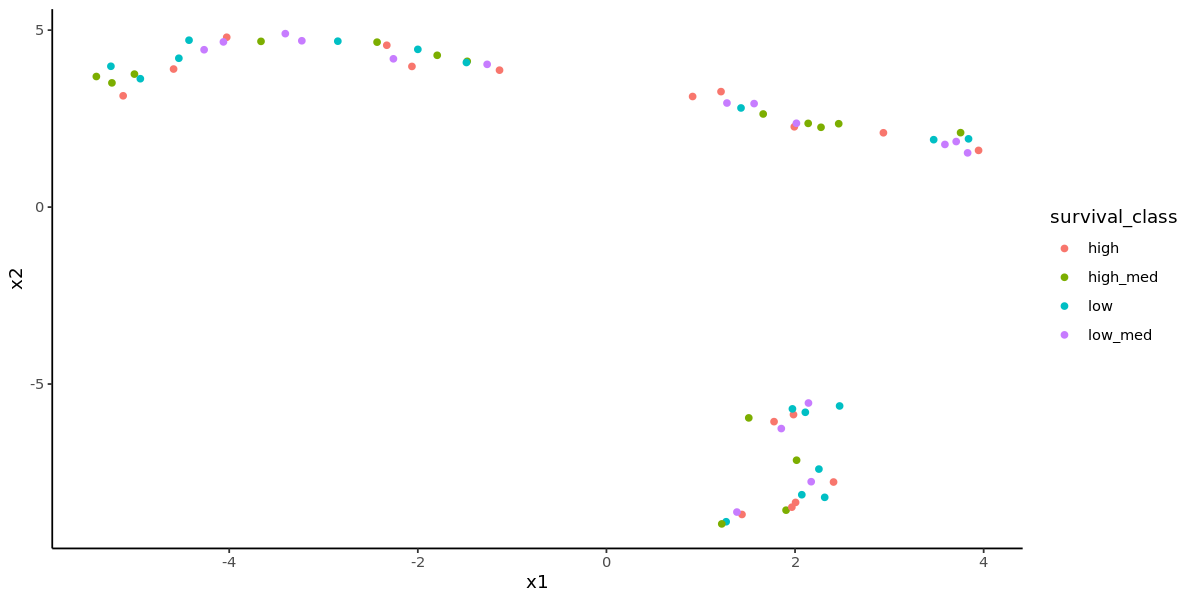

In [18]:
plt <- ggplot(umap_df) +
    geom_point(aes(x = x1, y = x2, color = survival_class)) +
    theme_classic()
plt